### Install required packages for training model


In [ ]:
!pip install gensim --upgrade
!pip install tensorflow-gpu --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

### Import packages

In [ ]:
# DataFrame
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Word2vec
from gensim.models import Word2Vec

# Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Dense, Dropout, Embedding, Conv1D, Concatenate, Bidirectional, LSTM, GlobalMaxPool1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Utils
import os
import re
import pickle
import numpy as np
import time
import itertools

# Plots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Test if GPU is avaliable
import tensorflow as tf
tf.config.list_physical_devices()

2022-11-09 12:42:18.189554: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

2022-11-09 12:42:18.189596: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (compute-2-04): /proc/driver/nvidia/version does not exist


# Data Preparation

### Import Data

The dataset file location should be

"../content/dataset/training.1600000.processed.noemoticon.csv"

In [ ]:
# Read raw dataset
dataset_columns = ["sentiment", "ids", "date", "flag", "user", "text"]
dataset_encoding = "ISO-8859-1"
dataset = pd.read_csv('../content/dataset/training.1600000.processed.noemoticon.csv',
                      encoding=dataset_encoding , names=dataset_columns)
dataset.head(5)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replace value 4 with 1 (positive)
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

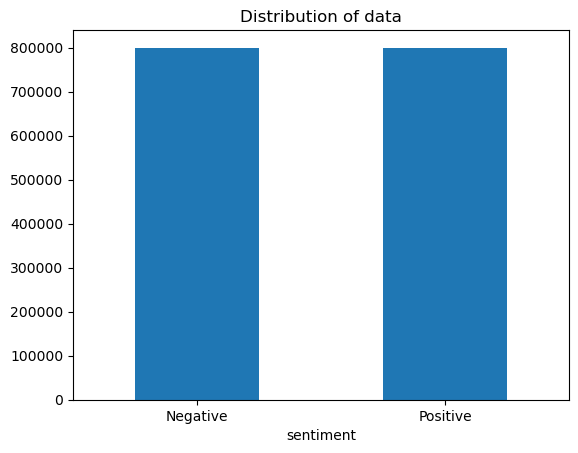

In [ ]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
ax = ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

### Pre-Process dataset

In [ ]:
# Load Enlgish contraction dictionary
contractions = pd.read_csv('../content/dataset/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Define text cleaning pattern
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Define emojis cleaning pattern
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

In [ ]:
def preprocess(text):
    
    # 1, Convert to lower case
    text = text.lower()

    # 2, Replace all URls with '<url>'
    text = re.sub(urlPattern, '<url>', text)
    
    # 3, Replace all @USERNAME to '<user>'.
    text = re.sub(userPattern, '<user>', text)
    
    # 4, Replace 3 or more consecutive letters by 2 letter.
    text = re.sub(sequencePattern, seqReplacePattern, text)

    # 5, Replace all emojis.
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(smileemoji, '<smile>', text)
    text = re.sub(sademoji, '<sadface>', text)
    text = re.sub(neutralemoji, '<neutralface>', text)
    text = re.sub(lolemoji, '<lolface>', text)

    # 6, Remove Contractions
    for contraction, replacement in contractions_dict.items():
        text = text.replace(contraction, replacement)

    # 7, Removing Non-Alphabets and replace them with a space
    text = re.sub(alphaPattern, ' ', text)

    # 8, Adding space on either side of '/' to seperate words.
    text = re.sub(r'/', ' / ', text)
    
    return text

In [ ]:
%%time

# Clean up the text and store it in a new field
dataset['processed_text'] = dataset.text.apply(preprocess)

CPU times: user 45.6 s, sys: 137 ms, total: 45.8 s
Wall time: 45.8 s


In [ ]:
# Show a sample processed result
sample_idx = 10
print("Original  Text: ", dataset.iloc[sample_idx][1])
print("Processed Text: ", dataset.iloc[sample_idx][2])

Original  Text:  spring break in plain city... it's snowing 
Processed Text:  spring break in plain city   it is snowing 


### Split training and testing set

In [ ]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print("TRAIN size:", len(y_train))
print("TEST size:", len(y_test))

TRAIN size: 1520000
TEST size: 80000


### Word embedding

In [ ]:
%%time

w2v_model_path = '../content/model/w2v-twitter-100'

# Load the word2vec model if previously trained
if os.path.exists(w2v_model_path):
    w2v_model = Word2Vec.load(w2v_model_path)

# Train a new word2vec model
else:
    # Parameters
    w2v_size = 100
    w2v_window = 7
    w2v_min_count = 10

    # Training set for w2v model
    w2v_training_data = list(map(lambda x: x.split(), X_train))

    # Defining w2v model and training it.
    w2v_model = Word2Vec(w2v_training_data,
                         vector_size = w2v_size,
                         workers = w2v_window,
                         min_count = w2v_min_count)

CPU times: total: 297 ms
Wall time: 303 ms


In [ ]:
# Demonstrate result
print("Vocabulary Length:", len(w2v_model.wv.key_to_index))
print("Similar words to 'love'")
w2v_model.wv.most_similar("love")

Vocabulary Length: 33184
Similar words to 'love'


[('loove', 0.8175401091575623),
 ('adore', 0.7835016250610352),
 ('lovee', 0.776652991771698),
 ('luv', 0.701998233795166),
 ('loved', 0.6603273153305054),
 ('miss', 0.6493878364562988),
 ('admire', 0.5970932245254517),
 ('loves', 0.5950676202774048),
 ('appreciate', 0.5874595642089844),
 ('liked', 0.5526801943778992)]

### Tokenize text

In [ ]:
%%time

tokenizer_path = '../content/model/Tokenizer.pickle'

# Load the tokenizer if previously trained
if os.path.exists(tokenizer_path):
    tokenizer = pickle.load(open(tokenizer_path, 'rb'))
    
# Train a tokenizer
else:
    vocab_size = 100000
    tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
    tokenizer.fit_on_texts(X_data)
    tokenizer.num_words = vocab_size

# vocab_size = len(tokenizer.word_index) + 1
print("Total words", tokenizer.num_words)

Total words 100000
CPU times: user 162 ms, sys: 24.1 ms, total: 187 ms
Wall time: 199 ms


### Padding text

In [ ]:
input_length = 60

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

NameError: name 'X_train' is not defined

# Model Building And Training

### Build Model

In [ ]:
# Embedding layer
def EmbeddingLayer():
    
    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    # print("Embedding Matrix Shape:", embedding_matrix.shape)

    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

    # Return embedding layer
    return Embedding(input_dim = vocab_size,
                     output_dim = w2v_size,
                     weights = [embedding_matrix],
                     input_length = input_length,
                     trainable = False)

In [ ]:
# Bi-LSTM + CNN
def Bi_LSTM():
    model = Sequential([
        EmbeddingLayer(),
        Bidirectional(LSTM(60, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(60, dropout=0.3, return_sequences=True)),
        Conv1D(60, kernel_size=5, activation='relu'),
        GlobalMaxPool1D(), 
        Dense(1, activation='sigmoid'),
    ])
    
    return model

# C-LSTM Model
def C_LSTM():
    input_layer = Input(shape = (input_length))
    embedding_layer = EmbeddingLayer()
    x = embedding_layer(input_layer)
    x = Dropout(0.2)(x)

    conv2 = Conv1D(16, kernel_size=2, activation='relu')(x)
    conv3 = Conv1D(16, kernel_size=3, activation='relu')(x)
    conv5 = Conv1D(16, kernel_size=5, activation='relu')(x)
    conv7 = Conv1D(16, kernel_size=7, activation='relu')(x)
    conv_len = conv7.shape[1]
    x = Concatenate(axis=-1)([conv2[:,:conv_len,:], 
                              conv3[:,:conv_len,:], 
                              conv5[:,:conv_len,:], 
                              conv7[:,:conv_len,:]])

    x = LSTM(128, dropout=0.2, activation='relu', return_sequences=True)(x)
    x = LSTM(128, dropout=0.2, activation='relu')(x)

    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=x)
    
    return model

# LSTM Model
def Pure_LSTM():
    model = Sequential()
    model.add(EmbeddingLayer())
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

### Loading or Training Model

In [ ]:
load_model = True
# Load a model if already trained
if load_model:
    model = keras.models.load_model(model_path)


# Train a new model
else:
    model = C_LSTM()
    # model = Bi_LSTM()
    # model = Pure_LSTM()
    
    model.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    
    
model.summary()

In [ ]:
%%time

if not load_model:

    # Training parameters
    epochs = 6
    batch_size = 512

    # Define callbacks
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),\
                 EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

    # Start training
    history = model.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_split = 0.1,
                        verbose = 1,
                        callbacks = callbacks)

### Evaluate

In [ ]:
%%time

score = model.evaluate(X_test, y_test, batch_size = batch_size)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

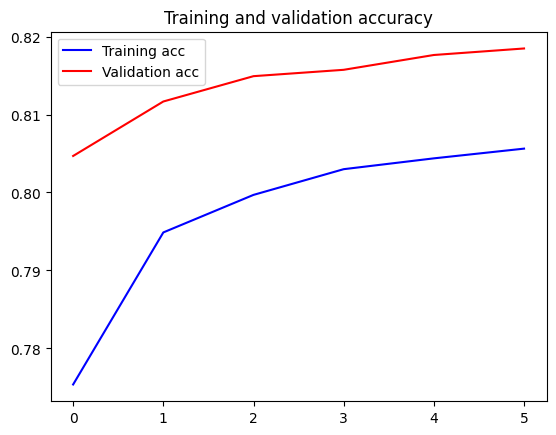

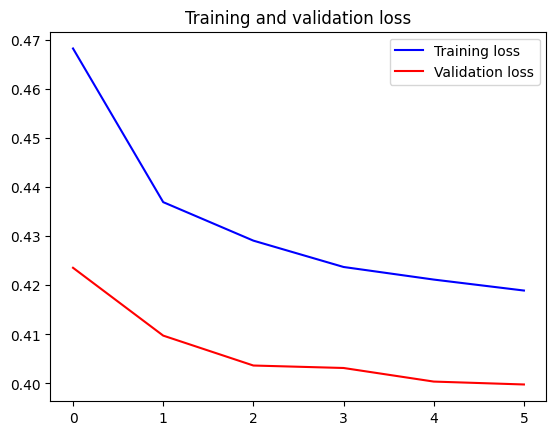

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict samples

In [ ]:
def predict(text):
    # Pre-process text
    processed_text = preprocess(text)
    # Tokenize text
    input_matrix = pad_sequences(tokenizer.texts_to_sequences([processed_text]), maxlen=input_length)
    # Predict
    score = model.predict([input_matrix])[0]
    
    return float(score)

In [ ]:
predict("I love the music!!")

1/1 [==============================] - 0s 369ms/step


0.9803897738456726

In [ ]:
predict("I hate the rain :(")

1/1 [==============================] - 0s 40ms/step


0.014086853712797165

In [ ]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 40ms/step


0.1559772938489914

# Model Analysis

### Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
    # Compute and plot the Confusion matrix
    print(y_test)
    print(y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    
    classes  = ['Negative', 'Positive']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.title('Confusion Matrix', fontsize=30)
    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

# Predicting on the Test dataset
y_pred = model.predict(X_test, batch_size = batch_size)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

157/157 [==============================] - 8s 48ms/step
CPU times: total: 9.25 s
Wall time: 8.02 s


[0 0 0 ... 0 1 1]
[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]


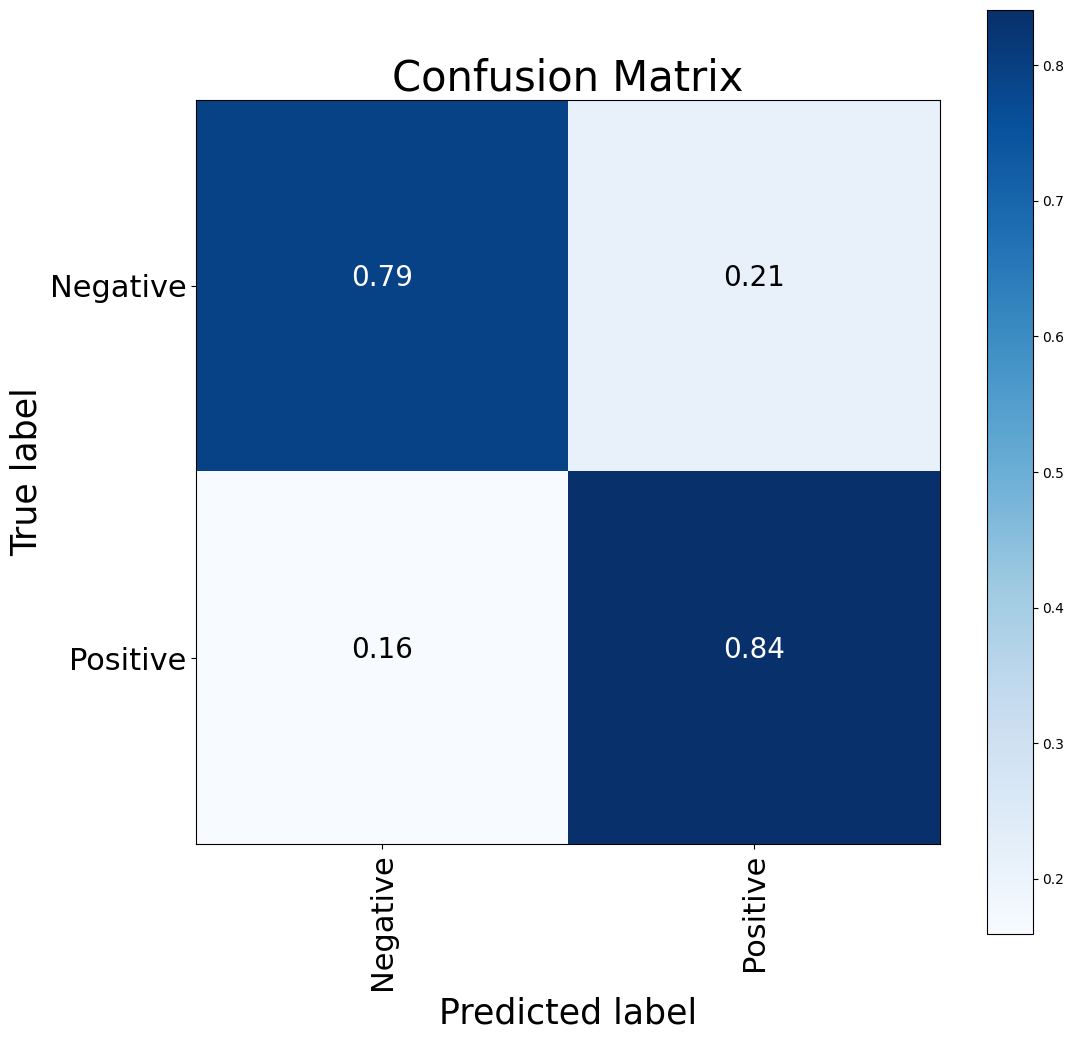

In [ ]:
# Printing out the Evaluation metrics. 
plot_confusion_matrix(y_test, y_pred)

### Classification Report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81     39989
           1       0.80      0.84      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



### Save model

In [ ]:
# Saving Word2Vec-Model
w2v_model.save(w2v_model_path)

# Saving the tokenizer
with open(tokenizer_path, 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
model.save(model_path)